In [2]:
from acquire import acquire_data
from wrangle import wrangle_data

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import linregress

from math import sqrt

# Aqcuisition

In [3]:
df = acquire_data()

csv has been previously generated.
Data Acquired


In [4]:
df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,fips,FIPS,Name,State
0,0,3.0,2.0,1458.0,136104.0,2319.90,6037.0,6037,Los Angeles,CA
1,1,2.0,1.0,1421.0,35606.0,543.69,6037.0,6037,Los Angeles,CA
2,2,3.0,2.0,1650.0,614000.0,7673.19,6037.0,6037,Los Angeles,CA
3,3,2.0,1.0,693.0,274237.0,3267.47,6037.0,6037,Los Angeles,CA
4,4,0.0,0.0,1378.0,168828.0,2135.39,6037.0,6037,Los Angeles,CA


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 10 columns):
Unnamed: 0                      15036 non-null int64
bedroomcnt                      15036 non-null float64
bathroomcnt                     15036 non-null float64
calculatedfinishedsquarefeet    15012 non-null float64
taxvaluedollarcnt               15036 non-null float64
taxamount                       15035 non-null float64
fips                            15036 non-null float64
FIPS                            15036 non-null int64
Name                            15036 non-null object
State                           15036 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 1.1+ MB


In [6]:
print(f'Total number of rows: {len(df)}')

Total number of rows: 15036


# Preparation

In [7]:
seed = 115
train_size = .8

train, test = wrangle_data(df, seed, train_size)

Data Prepared and Split


In [8]:
train.head()

,bedroom_count,bathroom_count,total_sqft,property_value,tax_amount,county,state
13032,2.0,2.0,1194.0,371363.0,4111.36,Orange,CA
1502,3.0,2.0,1794.0,705598.0,8693.67,Los Angeles,CA
4736,3.0,2.0,1215.0,185287.0,2437.92,Los Angeles,CA
11558,3.0,2.5,1709.0,653422.0,7024.88,Orange,CA
6444,4.0,6.0,5862.0,1279726.0,15645.06,Los Angeles,CA


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 13032 to 6949
Data columns (total 7 columns):
bedroom_count     11991 non-null float64
bathroom_count    11991 non-null float64
total_sqft        11991 non-null float64
property_value    11991 non-null float64
tax_amount        11991 non-null float64
county            11991 non-null object
state             11991 non-null object
dtypes: float64(5), object(2)
memory usage: 749.4+ KB


# Exploration

## Exploration Goals

* Create graphs that highlights the effect these three features have on the price of a home
* Get an idea of underlying patterns in the data

## Graphs

Text(0.5, 0.98, 'What Affects Taxes Most')

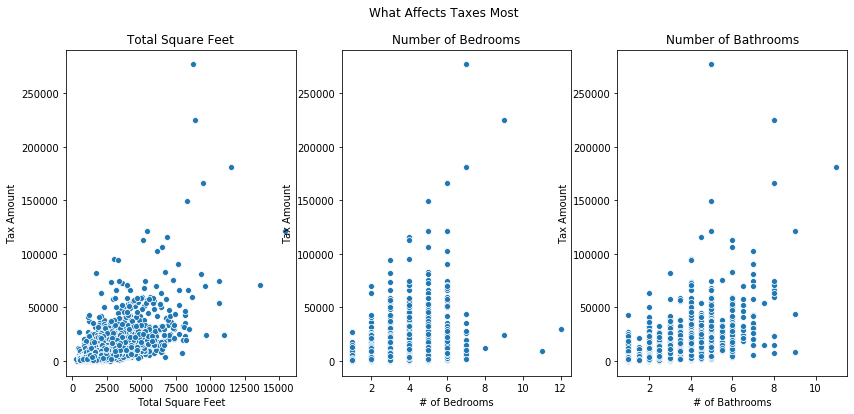

In [10]:
# Figure: Scatterplot of Features

y = train.tax_amount

plt.figure(figsize=(14,6))

# Left graph
plt.subplot(131)
sns.scatterplot(train.total_sqft, y)
plt.title('Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('Tax Amount')

# Center graph
plt.subplot(132)
sns.scatterplot(train.bedroom_count, y)
plt.title('Number of Bedrooms')
plt.xlabel('# of Bedrooms')
plt.ylabel('Tax Amount')

# Right graph
plt.subplot(133)
sns.scatterplot(train.bathroom_count, y)
plt.title('Number of Bathrooms')
plt.xlabel('# of Bathrooms')
plt.ylabel('Tax Amount')

plt.suptitle('What Affects Taxes Most')

In [ ]:
# Figure: Pairplot of Features

sns.pairplot(df[['total_sqft', 'bedroom_count', 'bathroom_count', 'tax_amount']], kind='reg')
plt.suptitle('Correlation Between Square Feet, Bedrooms and Bathrooms', size=14, y=1.02)
plt.figure(figsize=(16, 16))

In [ ]:
corr = train.corr()
sns.heatmap(corr, cmap="BuGn")

# Modeling

## Create a Dataframe to Hold Actual and Predicted Values

In [ ]:
predictions = pd.DataFrame(
    {'actual': train.tax_amount})

## Create the Models

In [ ]:
# Model Using the Total Square Feet to Predict Tax Amount

x = train[['total_sqft']]
y = train.tax_amount

lm_sqft = LinearRegression().fit(x, y)

In [ ]:
# Model Using the Number of Bedrooms to Predict Tax Amount

x = train[['bedroom_count']]
y = train.tax_amount

lm_bedroom = LinearRegression().fit(x, y)

In [ ]:
# Model Using the Number of Bathrooms to Predict Tax Amount

x = train[['bathroom_count']]
y = train.tax_amount

lm_bathroom = LinearRegression().fit(x, y)

## Use the  Models to Create Predictions

In [ ]:
predictions['baseline'] = y.mean()
predictions['lm_sqft'] = lm_sqft.predict(x)
predictions['lm_bedroom'] = lm_bedroom.predict(x)
predictions['lm_bathroom'] = lm_bathroom.predict(x)

In [ ]:
predictions.head()

# Evaluation

## Use RMSE to Compare Models

In [ ]:
rmse_sqft = sqrt(mse(predictions.actual, predictions.lm_sqft))
rmse_bedroom = sqrt(mse(predictions.actual, predictions.lm_bedroom))
rmse_bathroom = sqrt(mse(predictions.actual, predictions.lm_bathroom))
rmse_baseline = sqrt(mse(predictions.actual, predictions.baseline))

In [ ]:
print('sqft: {: .2f}, bedroom: {: .2f}, bathroom: {: .2f}, baseline: {: .2f}'.format(rmse_sqft, rmse_bedroom, rmse_bathroom, rmse_baseline))

## Result

__Model using bathrooms as driver performed the best__. Additionally, model beats baseline indicating model is significant.